In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tesla-stock-price:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1007%2F1814%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240404%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240404T002130Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Df00f8dd3aa014dfe1b79de0d09bf37e30f04652813a86c8f119677114e59d9f52bca7577df52a09304145b3a52410827743b0d0d4d1df0dc53bb6d7f330c2d661d9d7d447001668998c332e22d14c842a91409a7c461ce64c8bbed24de4cd3ee701125c70d51d72059a839f058c754172d0877f9f40407b6d09422c7b8b3d7a9afc7a9879415155b52dc50dd1fc9c6c40419e4a5a4c2cfb22c3c4a40a580a32325315d96664a4dc62783e5e843cac45e3c5d5e9f2db895db97621e0f453fd66cf79fb99a65942504247fc81f47235d5fad07564561bb895bdaa5ac0dbc3d02bb55ad6d98479326ff04fe01764ba1d15fe941d36bacdfcb7d13dc24f053ffe226,sandp500:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1908%2F17155%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240404%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240404T002130Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D00d4afe0e1411f968110c52b7a33518de981b73235710c1dc0bb97896dcf71d6a94fbbf835c07e01114d2df9a3e47ac915928db46f84d160c22bcfeecc92f01b866fee4c10a7e60feb6eb78752415854235df97e4e53cf46e0136bdd915bdbd5e90de3f2d765a8a2f7e701c72653351198b41370382219ab1ac29ee927b7d016d033e34485c2b118e8d271f921ee572b4033ccb6609bdc3abddd4170ba8db3fc430c24749d5e9e0deb11a67d6830c3bd0e89708cd629d9a5aba1bd98f97610b43144a6ae60c7ca88744f0d7b545a4da955c40beea9eb22f5f50e3adfdf20839550ee4382a652b744d4777b71a067e5723b3826a723c6ce6b7a61b616c9fc89f4,amzn-dpz-btc-ntfx-adjusted-may-2013may2019:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F195545%2F433077%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240404%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240404T002130Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D344376e52a0f51a55f6fa6e9dd44b8a3b7a3baf4ec5d92039b8da9d5cea8e13256b737eed000a4389d7639a1078f81f9c42865ada0bc7dfd04c1ce9452c0e8ec4f80c2d04c52844baeb67947ec70ba9109d77a2fc0b4c92b295840c437a567dc9a2e23284327d234afb0f47ebf4bc047520a41ffbf7f40d63193a586674797b683188ca06e296e0faba4f87fa8d47f1ff655792c9216a9e63a81b9ec54f2a146c1863dd66933c0bdd52bcc4a713fa5603694172289c66d02f4774dc16d41692a14a5ccc1b7b3e1caf5477663fcdb1be6b6373abf7fda411458a1da96dd39d47a545b659e50de792f02a680aca6a4753e3c9fb5b1b07c5906ed330559e78b44a9,apple-aapl-historical-stock-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F533900%2F976925%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240404%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240404T002131Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7844b641477c6d9c63bf4217435e34c3863538e9d9d1dfd604393999945d60736b8e1c18843da2e005ba2a12cac3c6bc6e264b04bb6813694b0aedf59180cde565c9686b58f9efa4ed83c69659792414cd6144168931e3ecda4a723c6de18d31ec63699a71a82db55a389d42b5f36bc4f33d0783090e35f21e83f8b1814c3e63e310f82728b507396f30ac33de0285ad4f9cb8c329ea2bbb489f8680b8a4f269a619b3d0f490a89e52cee0cda553bc4b05c93672498b442ac640732040a872d0b806e1e7c09ff16f245c4c20f4d8462ace66997a121c7485aa06c066fcfaf8fbe7cd3a4fe431bb633cd421f137d3ca6dfec2e59a597422ea66f6f11d07436c9c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34499 bytes downloaded
Downloaded and uncompressed: tesla-stock-price
[==================================================] 20283917 bytes downloaded
Downloaded and uncompressed: sandp500
[==================================================] 30437 bytes downloaded
Downloaded and uncompressed: amzn-dpz-btc-ntfx-adjusted-may-2013may2019
[==================================================] 50651 bytes downloaded
Downloaded and uncompressed: apple-aapl-historical-stock-data
Data source import complete.


In [ ]:
!pip install -q yfinance

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime


# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)


company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.tail(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-03-20,176.139999,178.529999,174.639999,178.149994,178.149994,29947200,AMAZON
2024-03-21,179.990005,181.419998,178.149994,178.149994,178.149994,32824300,AMAZON
2024-03-22,177.750000,179.259995,176.750000,178.869995,178.869995,27964100,AMAZON
2024-03-25,178.009995,180.990005,177.240005,179.710007,179.710007,29815500,AMAZON
2024-03-26,180.149994,180.449997,177.949997,178.300003,178.300003,29659000,AMAZON
2024-03-27,179.880005,180.000000,177.309998,179.830002,179.830002,33272600,AMAZON
2024-03-28,180.169998,181.699997,179.259995,180.380005,180.380005,38051600,AMAZON
2024-04-01,180.789993,183.000000,179.949997,180.970001,180.970001,29174500,AMAZON
2024-04-02,179.070007,180.789993,178.380005,180.690002,180.690002,32611500,AMAZON


In [ ]:
# Summary Stats
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,180.829921,182.271594,179.486055,180.968446,180.517877,5.736609e+07
std,9.261545,9.139694,9.200936,9.158916,9.217482,1.724752e+07
min,161.220001,162.029999,159.779999,160.100006,159.249985,2.404830e+07
25%,173.139999,174.345001,171.930000,173.565002,173.105247,4.670805e+07
50%,180.669998,182.229996,178.550003,180.710007,180.238220,5.342310e+07
75%,189.294998,189.990005,187.695000,189.334999,188.909805,6.212460e+07
max,198.020004,199.619995,197.000000,198.110001,197.857529,1.366826e+08


In [ ]:
# General info
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2023-04-04 to 2024-04-03
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          251 non-null    float64
 1   High          251 non-null    float64
 2   Low           251 non-null    float64
 3   Close         251 non-null    float64
 4   Adj Close     251 non-null    float64
 5   Volume        251 non-null    int64  
 6   company_name  251 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.7+ KB


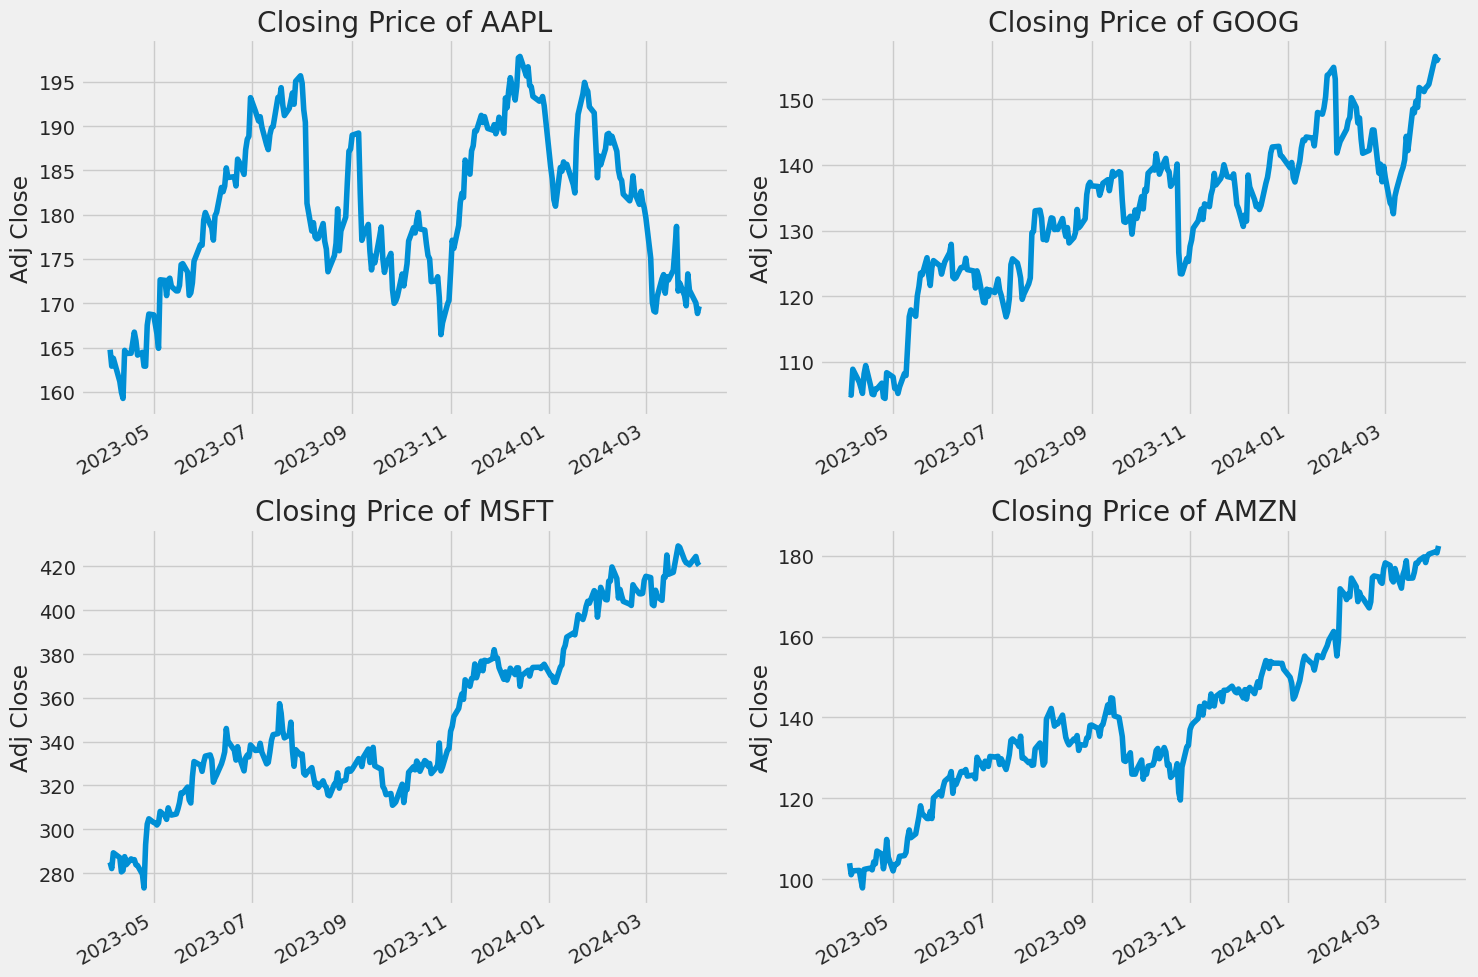

In [ ]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")

plt.tight_layout()

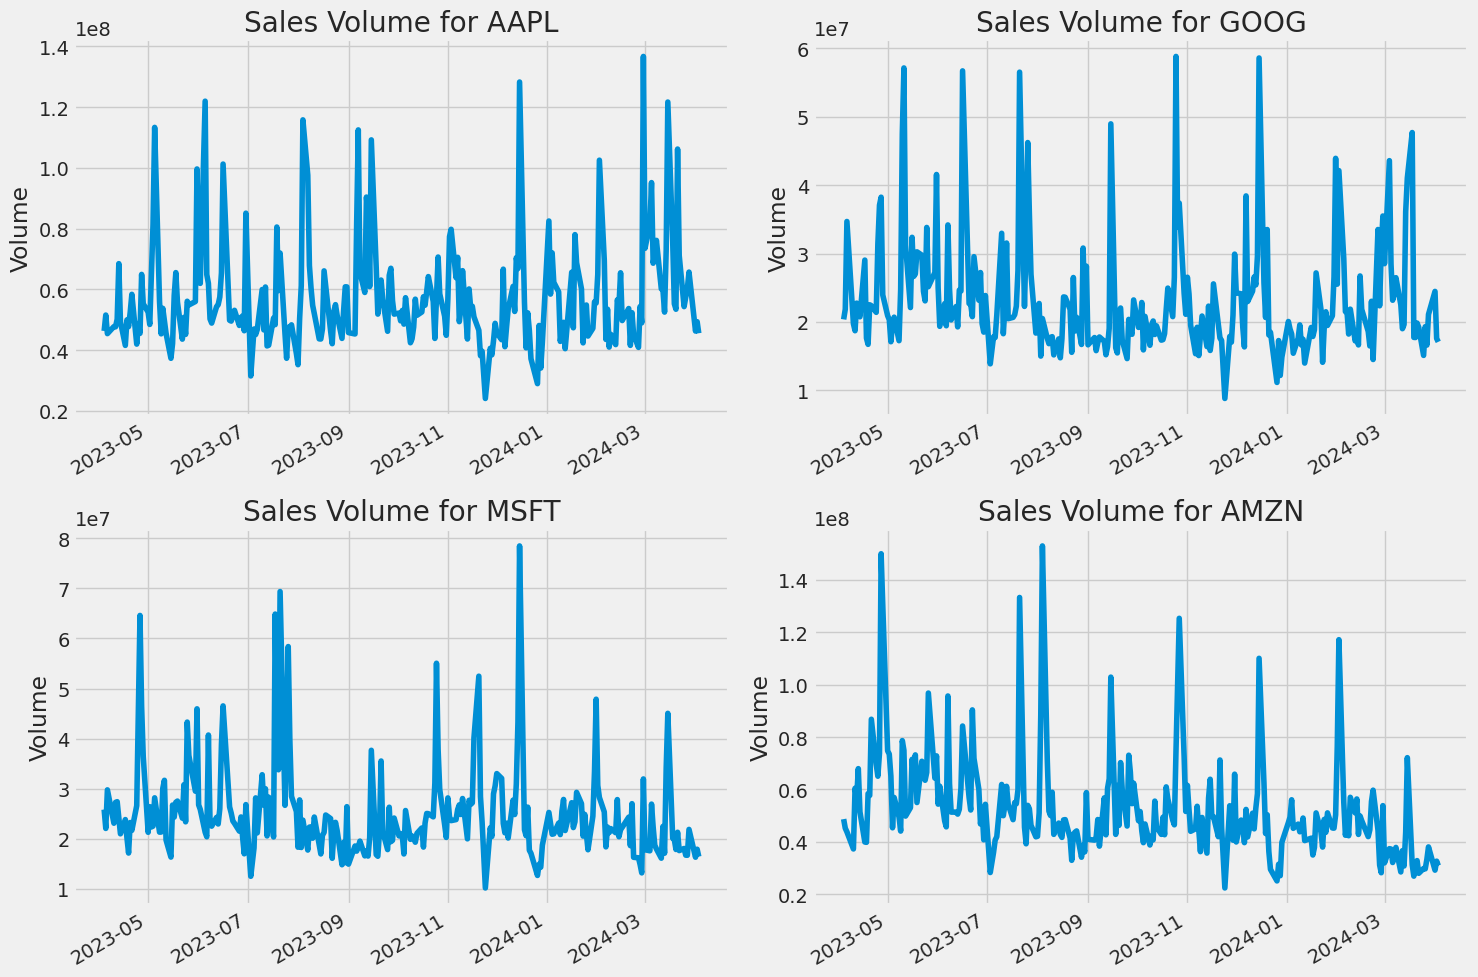

In [ ]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")

plt.tight_layout()

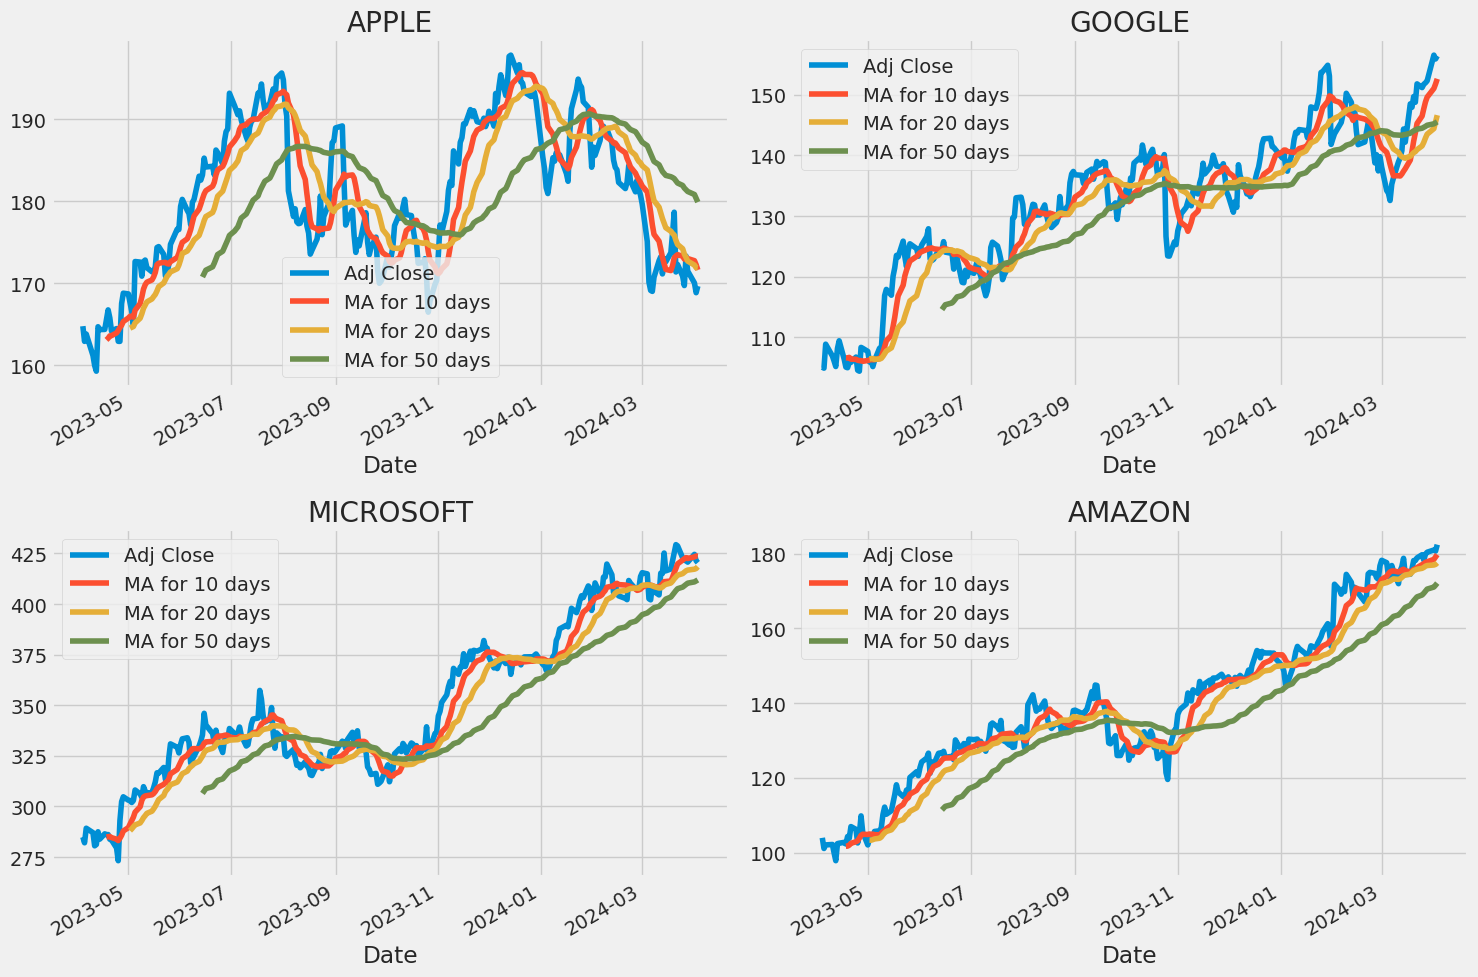

In [ ]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()


fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()

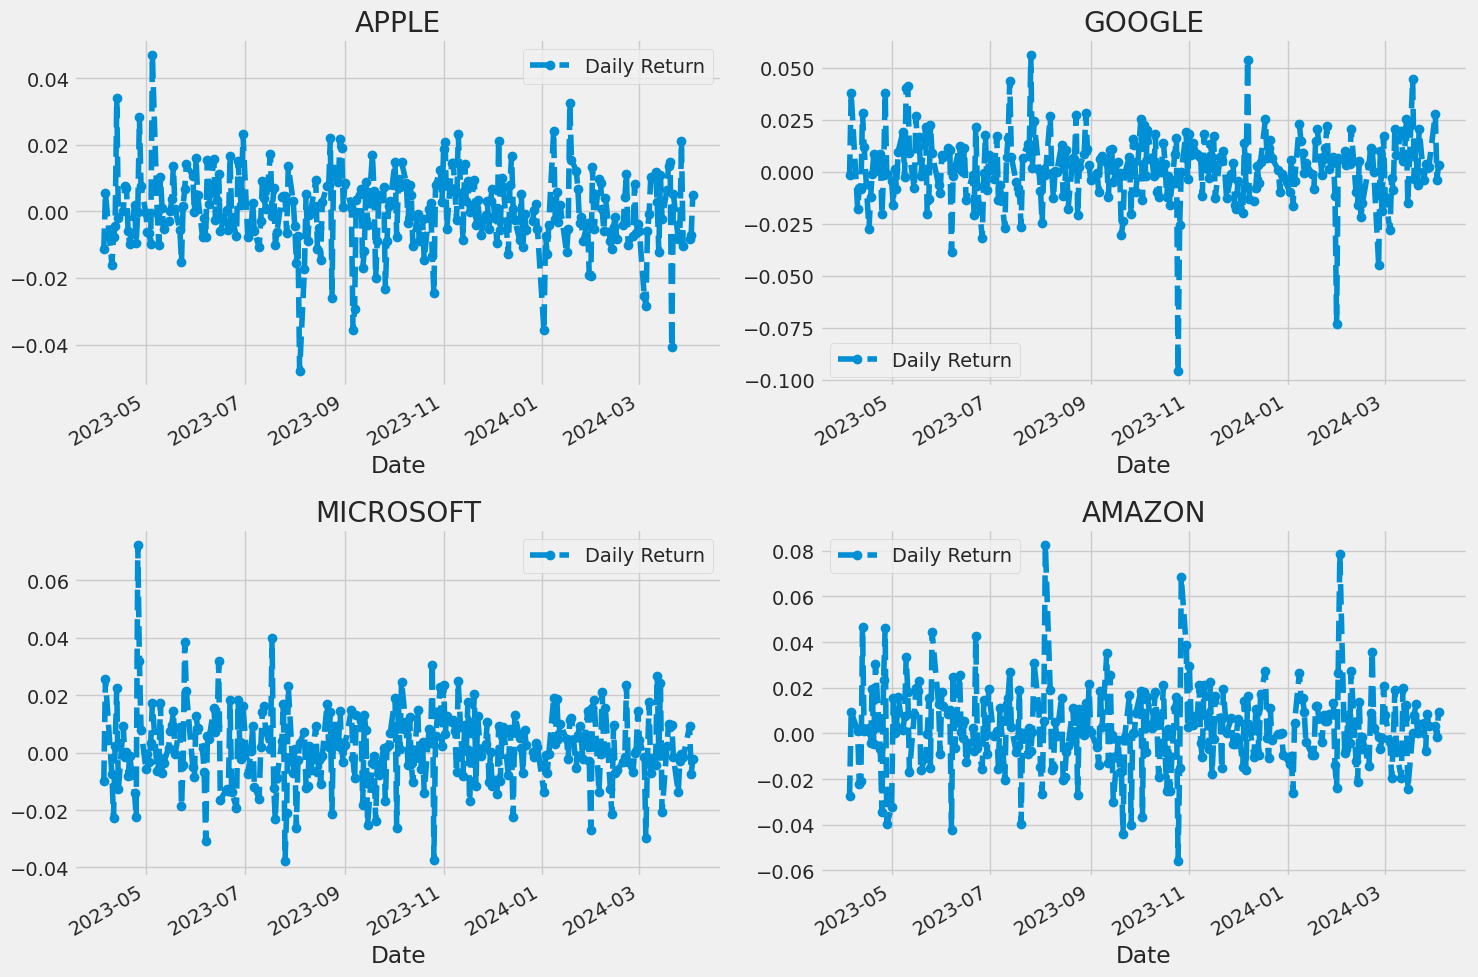

In [ ]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

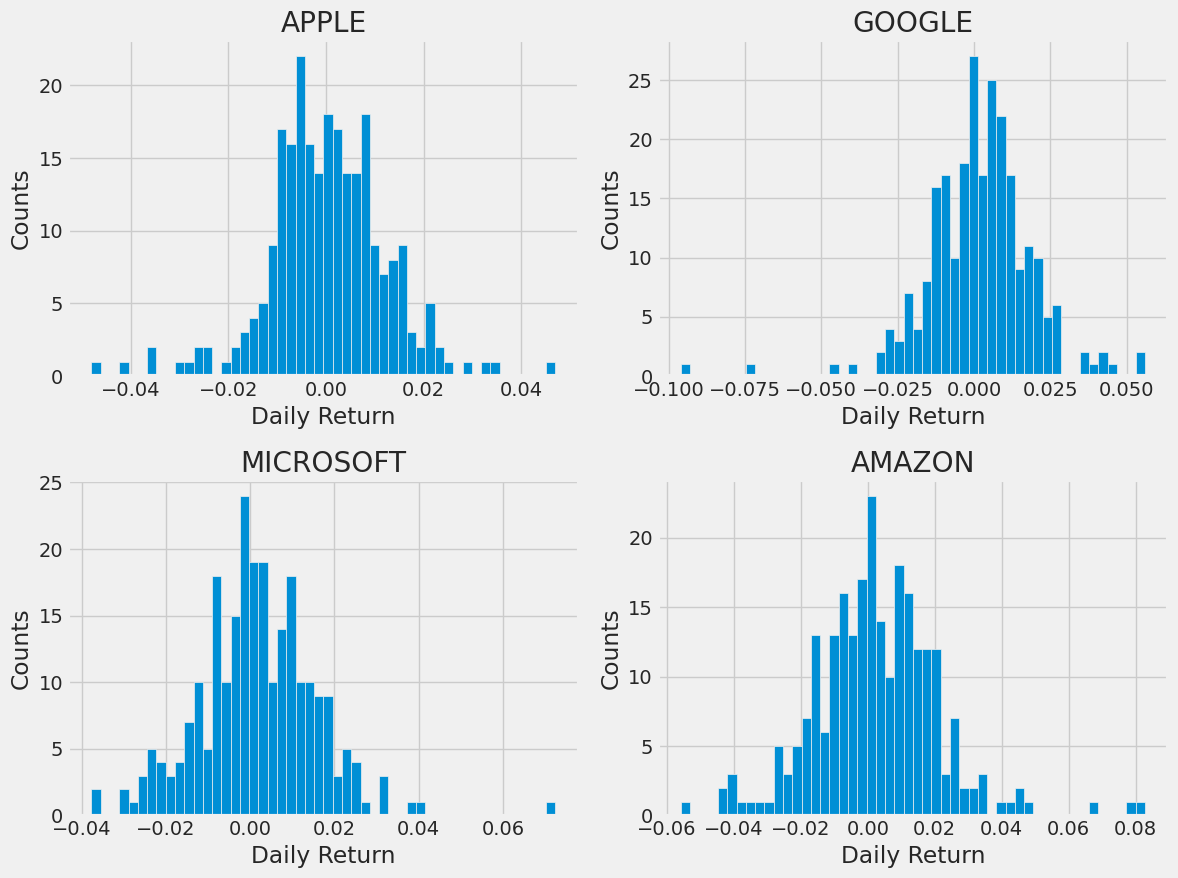

In [ ]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')

plt.tight_layout()

In [ ]:
# Grab all the closing prices for the tech stock list into one DataFrame

closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2023-04-04,NaN,NaN,NaN,NaN
2023-04-05,-0.011290,-0.027417,-0.001617,-0.009889
2023-04-06,0.005496,0.009496,0.037637,0.025533
2023-04-10,-0.015972,0.001078,-0.017906,-0.007579
2023-04-11,-0.007591,-0.022022,-0.007761,-0.022669


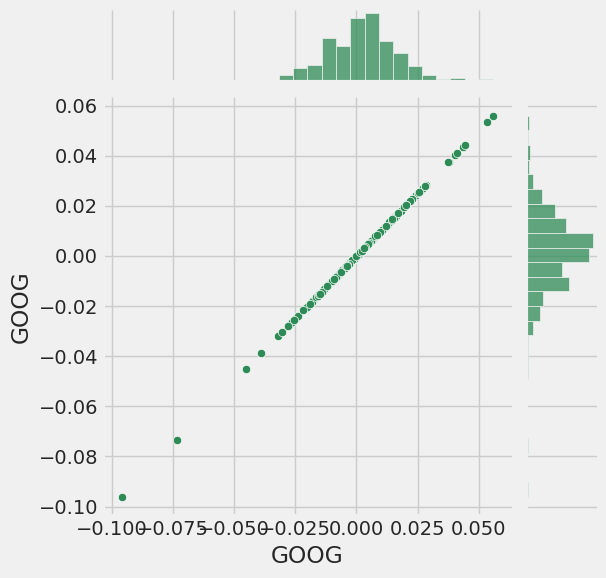

In [ ]:
# Comparing Google to itself should show a perfectly linear relationship
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

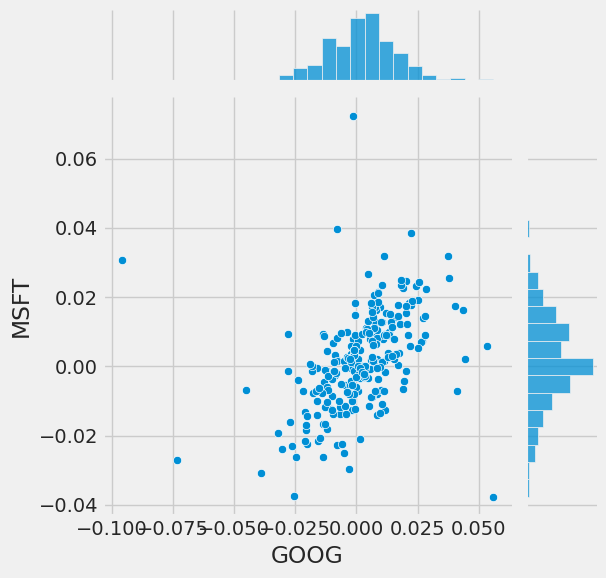

In [ ]:
# We'll use joinplot to compare the daily returns of Google and Microsoft
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter')

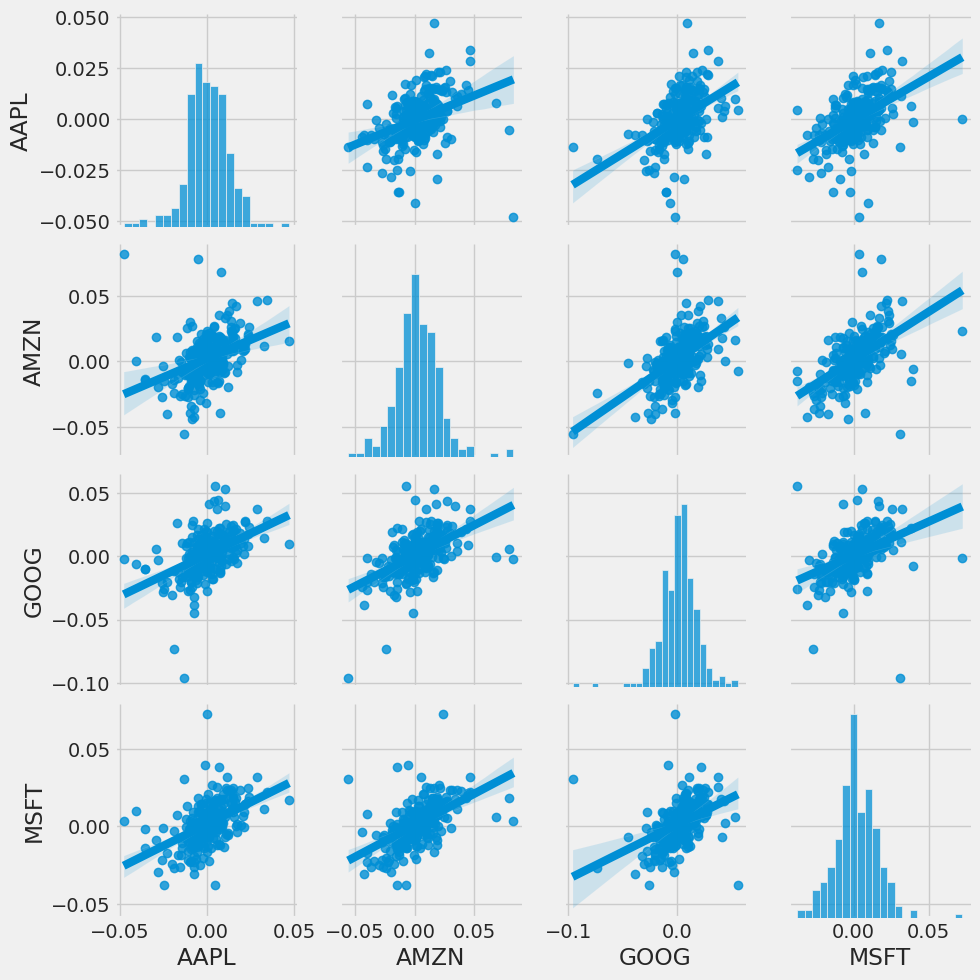

In [ ]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis
# of all the comparisons

sns.pairplot(tech_rets, kind='reg')

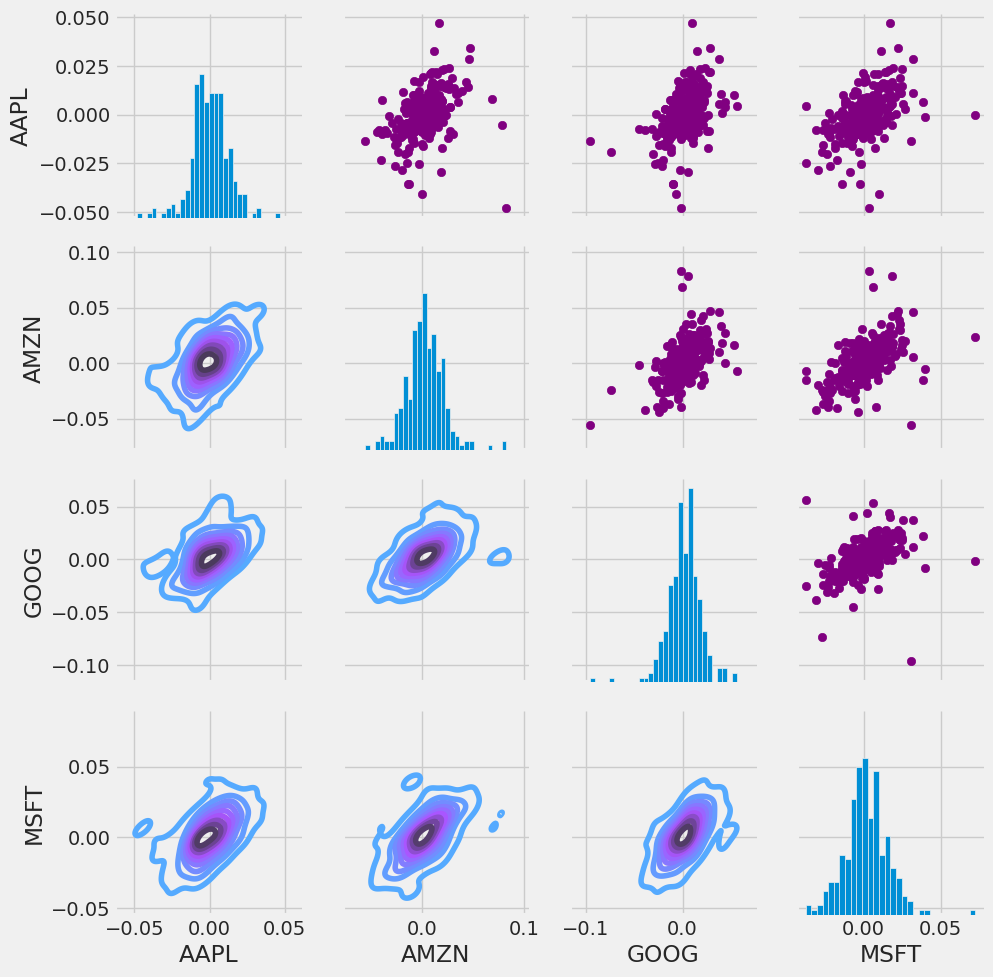

In [ ]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde)
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

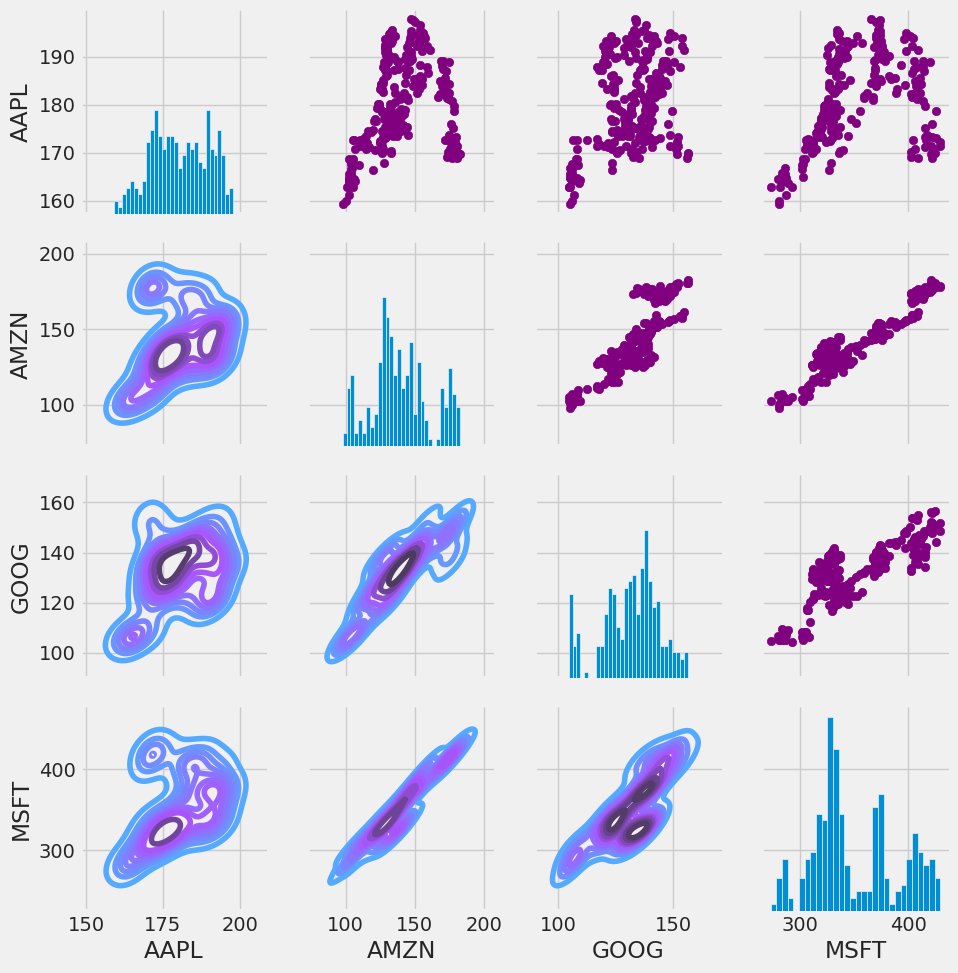

In [ ]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

Text(0.5, 1.0, 'Correlation of stock closing price')

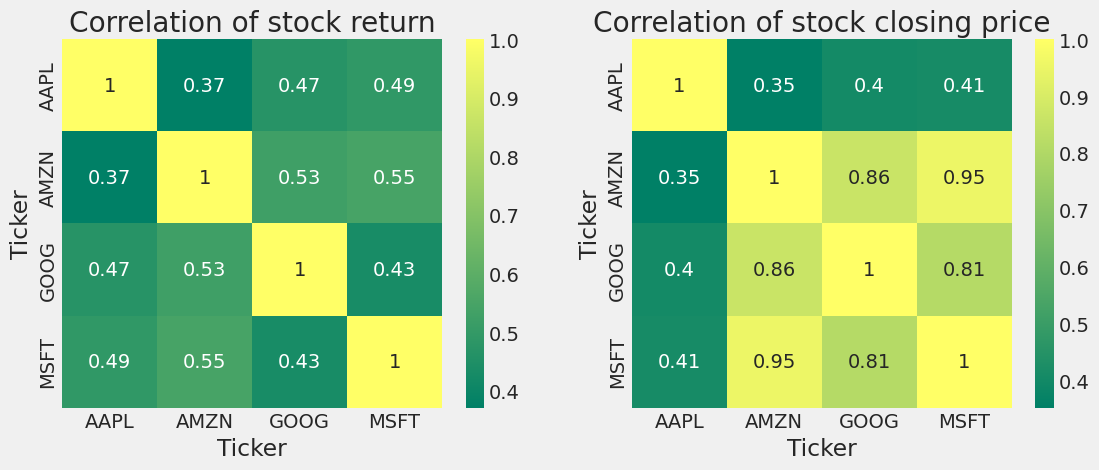

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

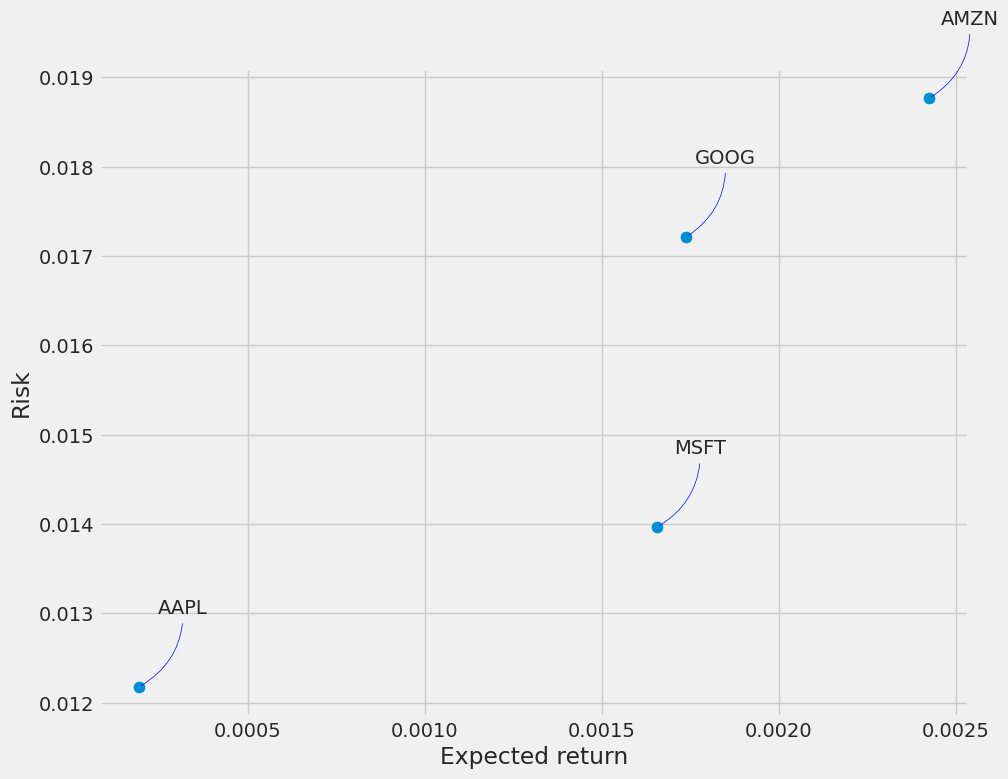

In [ ]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

#  Predicting the closing price stock price of APPLE inc:

In [ ]:
# Get the stock quote
df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
# Show teh data
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433825,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500646,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639431,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771556,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751300,394024400
...,...,...,...,...,...,...
2024-03-27,170.410004,173.600006,170.110001,173.309998,173.309998,60273300
2024-03-28,171.750000,172.229996,170.509995,171.479996,171.479996,65672700
2024-04-01,171.190002,171.250000,169.479996,170.029999,170.029999,46240500


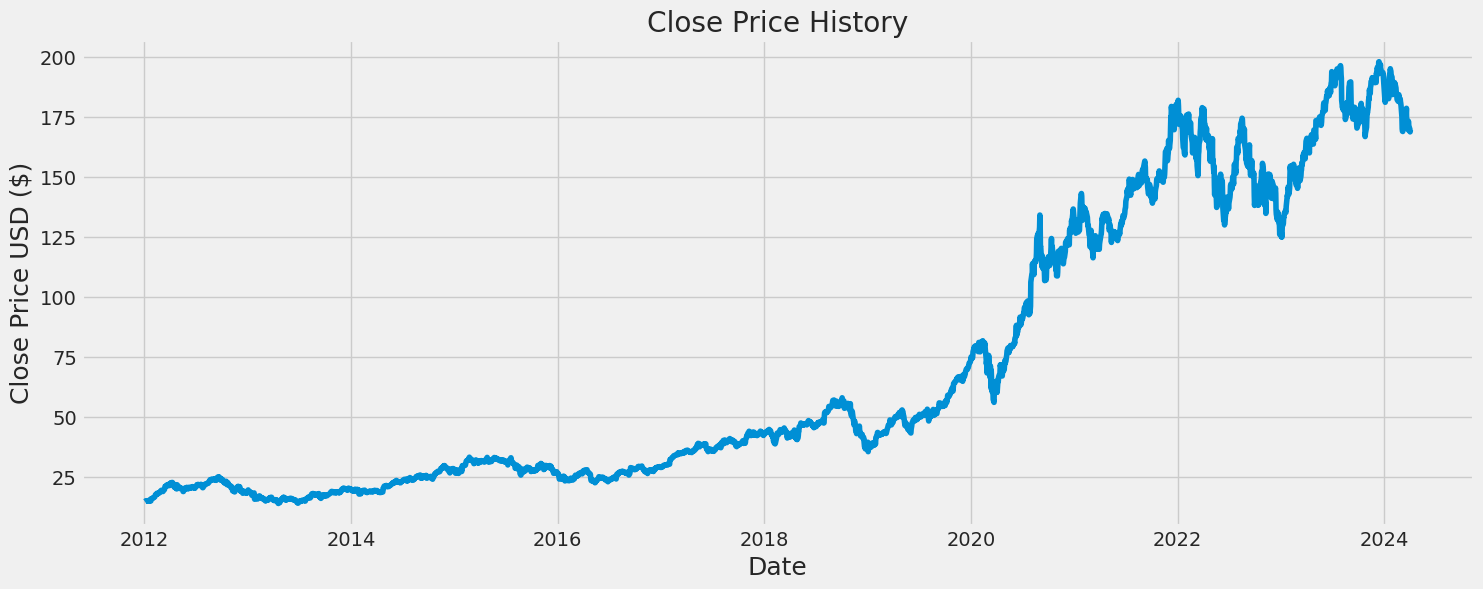

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [ ]:
# Create a new dataframe with only the 'Close column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2928

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00401431],
       [0.00444289],
       [0.00533302],
       ...,
       [0.84752595],
       [0.84106425],
       [0.84546253]])

In [ ]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.00577323, 0.00715207, 0.00579457,
       0.01088518, 0.01049151, 0.01100542, 0.01211663, 0.01278955,
       0.01273332, 0.01252582, 0.01341013, 0.01424207, 0.01518457,
       0.01670691, 0.01990478, 0.01995326, 0.02173353, 0.02306387,
       0.02077746, 0.02165789, 0.02164044, 0.02410915, 0.02375813,
       0.02440779, 0.02557523, 0.0262249 , 0.02809631, 0.02945961,
       0.02985329, 0.02999098, 0.02765997, 0.02709757, 0.02718096,
       0.02937236, 0.02998905, 0.03131358, 0.03443581, 0.03860139,
       0.0378218 , 0.03782373, 0.04083544, 0.04177794, 0.04110694,
       0.04049413, 0.03985611, 0.04197573, 0.0434302 , 0.04403914])]
[0.042534249860459186]

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.0

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2868/2868 [==============================] - 161s 55ms/step - loss: 0.0012


In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 1s 34ms/step


3.715147875151081

<ipython-input-27-0cdd5e68a3a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


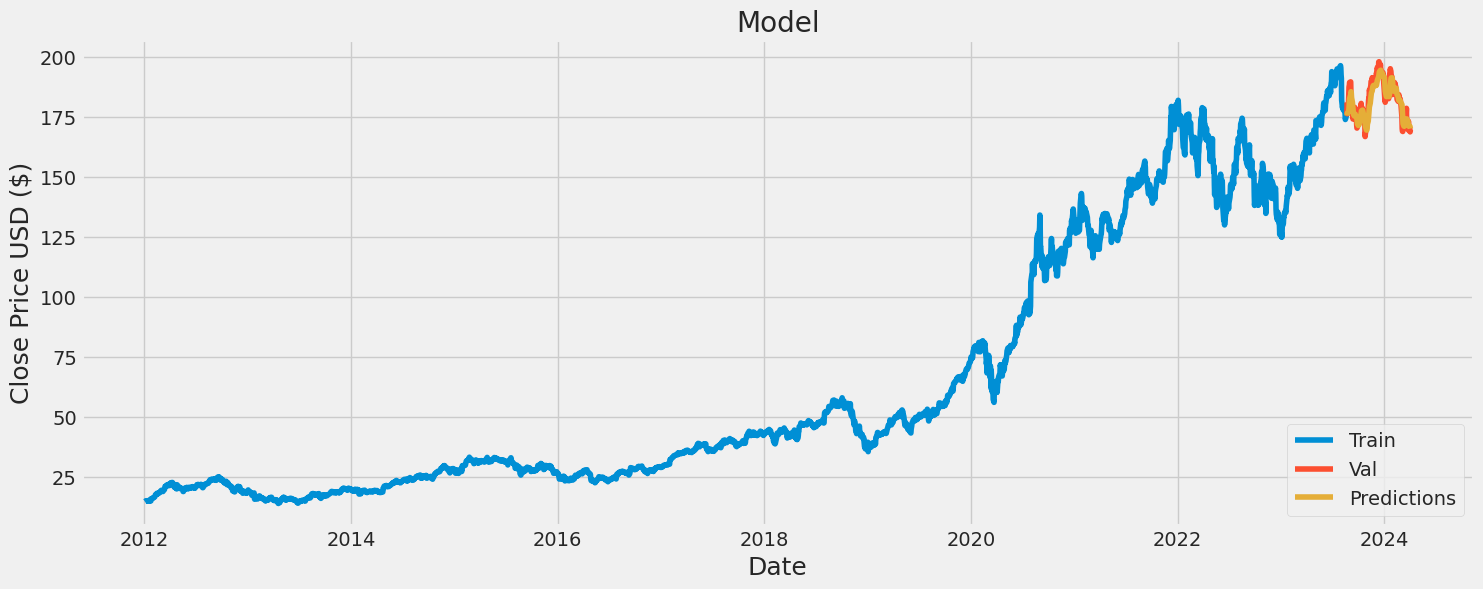

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2023-08-23,181.119995,175.623352
2023-08-24,176.380005,176.665253
2023-08-25,178.610001,176.817825
2023-08-28,180.190002,177.101212
2023-08-29,184.119995,177.649323
...,...,...
2024-03-27,173.309998,171.527847
2024-03-28,171.479996,171.424057
2024-04-01,170.029999,171.263809
